## Seattle Building prediction : energy and emission 

The goal is to predict carbon emission and total energy consumption of non-residential buildings of the city of Seattle.

Let's have a first look at the dataset given by the city of Seattle in this exploratory notebook. 

We will first handle : 
- Missing values and filter only non-residential building
- Have a closer look at variables that need to be predicted 
- Have a closer look on Location, property type and the year of build on consumption

and then select most interesting variables to prepare them for later prediction work.

In [100]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import pandas as pd
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import geopandas
import scikit_posthocs as sp
from scipy import stats
import warnings


In [101]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv', low_memory=False)

# I. Missing Values and first filtering

In [102]:
eData = data # exploratory data

In [103]:
print("Number of missing values per variable: \n")
NaNColumns = eData.isna().sum()
for i in range(len(NaNColumns)):
    if NaNColumns[i] != 0 :
        print(f"{str(NaNColumns.index[i]):<40}",round(NaNColumns.loc[NaNColumns.index[i]]/eData.shape[0] *100,3), "%")

Number of missing values per variable: 

ZipCode                                  0.474 %
NumberofBuildings                        0.237 %
ListOfAllPropertyUseTypes                0.267 %
LargestPropertyUseType                   0.592 %
LargestPropertyUseTypeGFA                0.592 %
SecondLargestPropertyUseType             50.267 %
SecondLargestPropertyUseTypeGFA          50.267 %
ThirdLargestPropertyUseType              82.346 %
ThirdLargestPropertyUseTypeGFA           82.346 %
YearsENERGYSTARCertified                 96.475 %
ENERGYSTARScore                          24.97 %
SiteEUI(kBtu/sf)                         0.207 %
SiteEUIWN(kBtu/sf)                       0.178 %
SourceEUI(kBtu/sf)                       0.267 %
SourceEUIWN(kBtu/sf)                     0.267 %
SiteEnergyUse(kBtu)                      0.148 %
SiteEnergyUseWN(kBtu)                    0.178 %
SteamUse(kBtu)                           0.267 %
Electricity(kWh)                         0.267 %
Electricity(kBtu)      

We need to select building from it's use type, so we will drop the individual if 'LargestPropertyUseType' is missing. 
As 'SiteEnergyUse(kBtu)' and  'TotalGHGEmissions' the value that needs to be predicted and negligible number of variables are missing, we can drop these individuals. 

In [104]:
eData.dropna(subset=['LargestPropertyUseType','LargestPropertyUseTypeGFA','SiteEnergyUse(kBtu)','TotalGHGEmissions'],inplace=True)

We will drop buildings  that have more than 90% missing values.
The 'Comments' variable is totally empty, we can drop it. 

In [105]:
eData.dropna(thresh=int(eData.shape[1]*0.8),axis=0,inplace=True)
eData.drop('Comments',axis=1,inplace=True)

Some columns have unique attribute and unneeded information : Name and TaxId, we choose to drop them.

In [106]:
idx = 0 
print(f"{str('ColumnName'):<40}", "mode" )
for i in data.nunique(): # number of unique value per column excluding NaNs
    if i == 1 :
        print(f"{str(data.nunique().index[idx]):<40}", i )
    idx = idx + 1 


ColumnName                               mode
DataYear                                 1
City                                     1
State                                    1


In [107]:
# Seattle, chief city of the state of Washington
## So unique city and state 
eData.drop(columns=['City','State','DataYear'],inplace=True)
# Drop Building Name and Tax Id and DefaultData  
eData.drop(columns=['PropertyName','TaxParcelIdentificationNumber','DefaultData'],inplace=True)

## Missing values handling
For Zipcode we complete missing values with the mode.

In [108]:
eData['ZipCode'].value_counts().head(1).index


Float64Index([98109.0], dtype='float64')

In [109]:
eData.loc[eData['ZipCode'].isna(), 'ZipCode']  = float(98109.0)

We complete ENERGYSTARScore with the median value.

In [110]:
eData.loc[eData['ENERGYSTARScore'].isna(), 'ENERGYSTARScore']  = eData['ENERGYSTARScore'].median()

Lots of second and third use types are missing. Indeed lots of building have only one or two types such as a school.
That is why if the value is missing we convert them to 'NoNe' type and replace the missing GFA (surface) by 0.

In [111]:
eData.loc[eData['SecondLargestPropertyUseType'].isna(), 'SecondLargestPropertyUseType']  = 'NoNe'
eData.loc[eData['ThirdLargestPropertyUseType'].isna(), 'ThirdLargestPropertyUseType']  = 'NoNe'

In [112]:
eData.loc[eData['SecondLargestPropertyUseTypeGFA'].isna(), 'SecondLargestPropertyUseTypeGFA']  = 0
eData.loc[eData['ThirdLargestPropertyUseTypeGFA'].isna(), 'ThirdLargestPropertyUseTypeGFA']  = 0

Check Duplicates 

In [113]:
data.duplicated().sum()

0

# First filtering : Outliers, compliant data and only non-residential building

In [114]:
eData['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

Outliers are qualified as "low" or "high" outliers.
We will drop them for further prediction.

In [115]:
mask = ( eData['Outlier'] ==  'High outlier' ) | ( eData['Outlier'] ==  'Low outlier')
eData.drop(eData[mask].index ,inplace=True)
eData.drop('Outlier',axis=1,inplace=True)

We  only select compliant or corrected data

In [116]:
eData['ComplianceStatus'].value_counts()

Compliant                       3196
Error - Correct Default Data     111
Missing Data                      15
Non-Compliant                      2
Name: ComplianceStatus, dtype: int64

In [117]:
mask = (eData['ComplianceStatus'] ==  'Missing Data') | ( eData['ComplianceStatus'] ==  'Non-Compliant' )
eData.drop(eData[mask].index ,inplace=True)
eData.drop('ComplianceStatus',axis=1,inplace=True)

### Filtering : building not intended for habitation : 



In [118]:
eData['LargestPropertyUseType'].value_counts().head()

Multifamily Housing           1650
Office                         492
Non-Refrigerated Warehouse     199
K-12 School                    124
Other                           98
Name: LargestPropertyUseType, dtype: int64

In [119]:
mask = (eData['LargestPropertyUseType'] ==  'Multifamily Housing' )
eData.drop(eData[mask].index ,inplace=True)

### NumberofFloors and NumberofBuildings abberants

In [120]:
eData[eData['NumberofFloors'] == 0 ].head(2)

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
166,267,NonResidential,Hotel,721 Pine St,98101.0,7,DOWNTOWN,47.61275,-122.33330,1999,...,278.200012,65047284.0,66502836.0,0.0,11536962.00,39364114.0,256831.625,25683162.0,1638.46,1.75
487,656,NonResidential,Medical Office,1221 Madison Street,98104.0,3,EAST,47.60979,-122.32298,2004,...,245.300003,20560622.0,20764814.0,7815663.0,3735333.25,12744957.0,0.000,0.0,692.12,3.06


In [121]:
eData[eData['NumberofBuildings'] == 0 ].head(2)

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
63,89,NonResidential,Medical Office,1200 Harvard Ave,98122.0,3,EAST,47.61244,-122.32140,1965,...,210.300003,16701055.00,16527711.00,0.0,2897562.75,9886484.0,68145.70313,6814570.0,430.84,2.41
76,113,NonResidential,Small- and Mid-Sized Office,401 Mercer St,98109.0,7,MAGNOLIA / QUEEN ANNE,47.62391,-122.34837,1986,...,236.600006,4166306.25,4192107.75,0.0,1221074.25,4166305.0,0.00000,0.0,29.04,0.44


This is clearly an error, NumberofBuildings should be 1 not  0 

In [122]:
eData.loc[eData['NumberofBuildings'] == 0 , 'NumberofBuildings']  = 1
eData.loc[eData['NumberofFloors'] == 0 , 'NumberofFloors']  = 1

# II. Variables to predict : 

There are multiple variables that correspond to total energy consumption and emission, we choose to select the one that are not normalized (by GFA or weather condition). 

**SiteEnergyUse(kBtu)** : The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions.

**TotalGHGEmissions** : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. 

Both of them are **quantitative continuous** variables. 

In [123]:
## Remove outliers
def drop_interquartile_outliers(column,dataFrame): 
    Q3 = np.quantile(column, 0.75)
    Q1 = np.quantile(column, 0.25)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    mask = (column < lower_range)  | ( column > upper_range )
    dataFrame.drop(column.loc[mask].index, inplace=True)

    
drop_interquartile_outliers(eData['TotalGHGEmissions'],eData)
drop_interquartile_outliers(eData['SiteEnergyUse(kBtu)'],eData)
 


We removed interquartile outliers, now we can have a closer look at both distribution : 

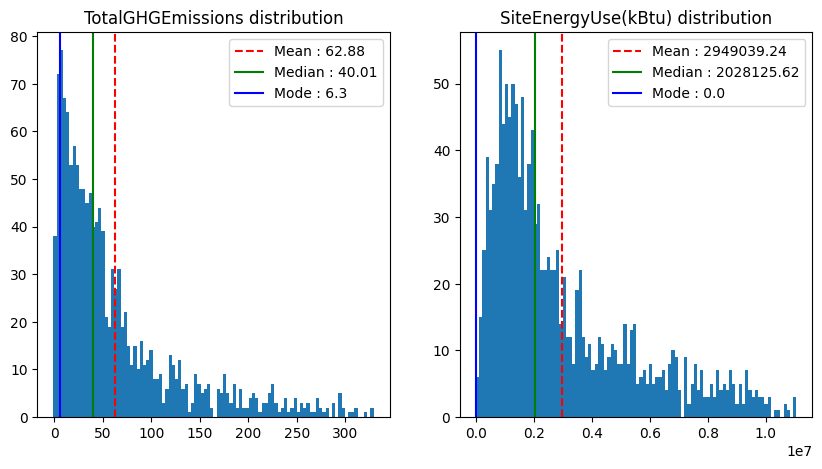

In [124]:

fig1, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# TotalGHGEmissions 
ax1.hist(eData['TotalGHGEmissions'], bins=100)
ax1.set_title('TotalGHGEmissions distribution')
mean    =   eData['TotalGHGEmissions'].mean()
median  =   eData['TotalGHGEmissions'].median()
mode    =   eData['TotalGHGEmissions'].mode().values[0]
ax1.axvline(mean,   color='r', linestyle='--',label="Mean : "   +   str(round(mean,2)))
ax1.axvline(median, color='g', linestyle='-', label="Median : " +   str(round(median,2)))
ax1.axvline(mode,   color='b', linestyle='-', label="Mode : "   +   str(round(mode,2)))
ax1.legend()
# 'SiteEnergyUse(kBtu)'
ax2.hist(eData['SiteEnergyUse(kBtu)'], bins=100)
ax2.set_title('SiteEnergyUse(kBtu) distribution')
mean    =   eData['SiteEnergyUse(kBtu)'].mean()
median  =   eData['SiteEnergyUse(kBtu)'].median()
mode    =   eData['SiteEnergyUse(kBtu)'].mode().values[0]
ax2.axvline(mean,   color='r', linestyle='--',label="Mean : "   +   str(round(mean,2)))
ax2.axvline(median, color='g', linestyle='-', label="Median : " +   str(round(median,2)))
ax2.axvline(mode,   color='b', linestyle='-', label="Mode : "   +   str(round(mode,2)))

ax2.legend()

plt.show()

In [125]:
#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))
print('TotalGHGEmissions')
print('Skewness : ' , round(eData['TotalGHGEmissions'].skew(),3))
print('Kurtosis  - Normal Kurtosis : ' , round(eData['TotalGHGEmissions'].kurtosis(),3))
print('Gini coefficient  : ' , round(gini(eData['TotalGHGEmissions']),3))
print('\nSiteEnergyUse(kBtu)')
print('Skewness : ' , round(eData['SiteEnergyUse(kBtu)'].skew(),3))
print('Kurtosis - Normal Kurtosis : ' , round(eData['SiteEnergyUse(kBtu)'].kurtosis(),3))
print('Gini coefficient : ' , round(gini(eData['SiteEnergyUse(kBtu)']),3))

TotalGHGEmissions
Skewness :  1.71
Kurtosis  - Normal Kurtosis :  2.567
Gini coefficient  :  0.521

SiteEnergyUse(kBtu)
Skewness :  1.218
Kurtosis - Normal Kurtosis :  0.642
Gini coefficient :  0.444


Both distributions are not symmetrical and skewed to the right.
This is confirmed by skewness coefficients larger than 0 and Gini coefficients which indicates an unequal distribution. 

Furthermore, the mean is superior to the median for both variables.

This indicates that some building have very high emission and consumption must most of them are concentrated on the right of the median value. 

Both distribution are leptokurtic with a higher peaks curve than the normal distribution (kurtosis coefficient).

Let's have a closer look at the relation between the two, distinguishing the main energy source :

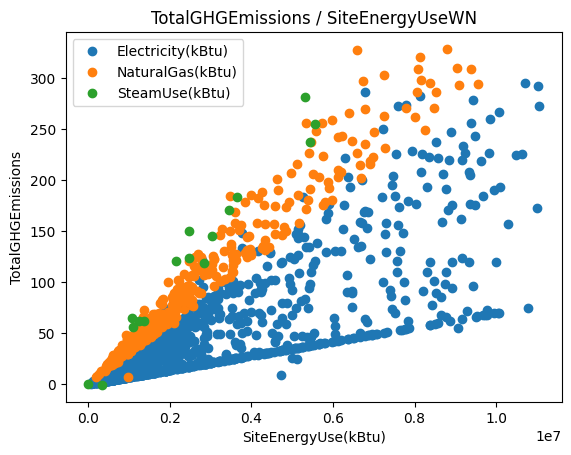

In [126]:
eData['HighestEnergyProvider'] = eData[['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']].idxmax(axis=1)
groups = eData.groupby('HighestEnergyProvider')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['SiteEnergyUse(kBtu)'], group['TotalGHGEmissions'], marker='o', linestyle='', label=name)
ax.set_xlabel('SiteEnergyUse(kBtu)')
ax.set_ylabel('TotalGHGEmissions')
ax.set_title('TotalGHGEmissions / SiteEnergyUseWN' )
ax.legend()
plt.show()
eData.drop('HighestEnergyProvider',axis=1,inplace=True)

GHG Emissions has an upper and lower bound in function of the SiteEnergyUse.

This can be explained as emission depends on the energy source (either gas, electricity, coal ... ).
The source with the highest carbon emission being Steam it is the higher bound and same for the lowest bound with electricity. 

Value with SiteEnergyUse equal to 0 are clearly **outliers**. 

To correct outliers we will take only these three sources ( steam, electricity, and Natural gas ) into account and replace the 0 value by the sum of these three variables. 

In [127]:
eData['SUM_ENERGYUse(kBtu)'] = eData[['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']].sum(axis=1)
eData.loc[eData['SiteEnergyUse(kBtu)'] == 0 , 'SiteEnergyUse(kBtu)']  = eData['SUM_ENERGYUse(kBtu)']
eData.drop( 'SUM_ENERGYUse(kBtu)',axis=1,inplace=True)

In [128]:
st.pearsonr(eData['TotalGHGEmissions'],eData['SiteEnergyUse(kBtu)'])[0]

0.735537679926264

There is a clear positive correlation between the two with a pearson coefficient of 0.723.




Douglas said : "Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées."
This mean that we should know if a certain building uses steam, electricity or gas as source of energy. Let's generate those new variables : 

In [ ]:
eData['SteamUsed']          = False
eData['ElectricityUsed']    = False
eData['NaturalGasUsed']     = False

eData.loc[eData['SteamUse(kBtu)'] > 0 , 'SteamUsed']            = True
eData.loc[eData['Electricity(kBtu)'] > 0 , 'ElectricityUsed']   = True
eData.loc[eData['NaturalGas(kBtu)' > 0 , 'NaturalGasUsed']  ]   = True

# III. Location and property type impact 

### The impact of Neighborhood 

In [129]:
eData['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'NORTH',
       'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'BALLARD',
       'GREATER DUWAMISH', 'NORTHWEST', 'CENTRAL', 'Ballard', 'DELRIDGE',
       'SOUTHWEST', 'North', 'Delridge', 'Northwest', 'Central',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

The same neighborhood can be in upper and lowercase, let's correct that : 

In [130]:
eData['Neighborhood'] = eData['Neighborhood'].str.upper()

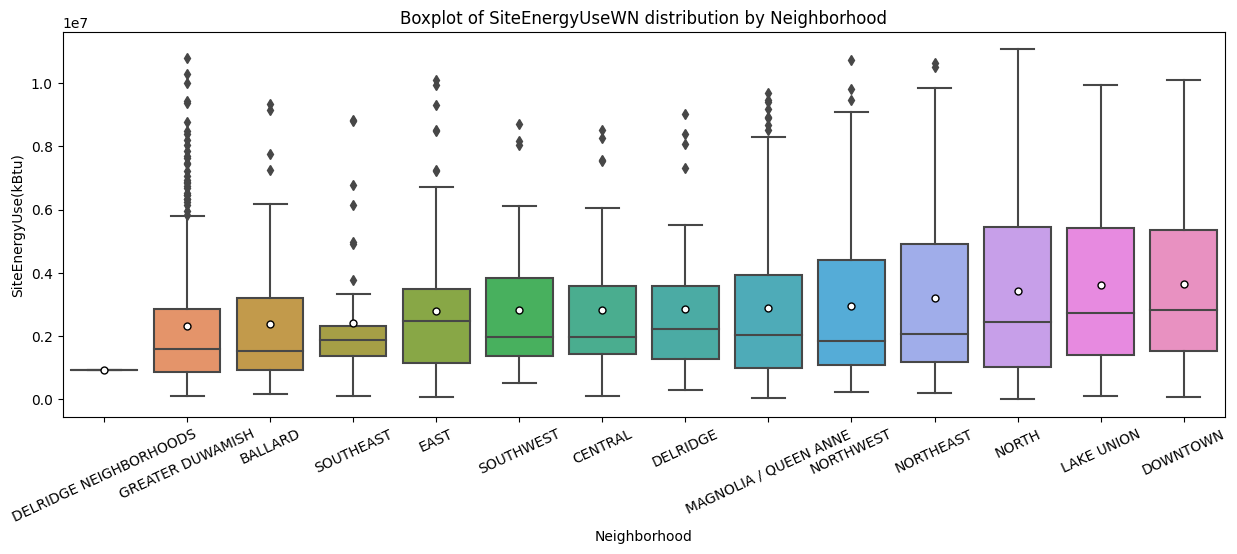

In [131]:
eData['Neighborhood']
plt.figure(figsize=(15, 5))
my_order = eData.groupby('Neighborhood')['SiteEnergyUse(kBtu)'].mean().sort_values().index
sns.boxplot(data=eData, y='SiteEnergyUse(kBtu)', x='Neighborhood',\
                order = my_order,
                showmeans=True,
                meanprops={"marker":"o",    
                            "markerfacecolor":"white", 
                            "markeredgecolor":"black",
                            "markersize":"5"})
plt.xticks(rotation = 25) # Rotates X-Axis Ticks by 45-degrees
plt.title("Boxplot of SiteEnergyUseWN distribution by Neighborhood")
plt.show()

Based on the boxplot it seems that Building from Lake union and EAST have a higher energy consumption and BALLARD and Greater Duwamish a lower. 

To compare the different group and verify our assumption we need to pursue with a statistical test.

Let's look at the variance between each group through a Levene test (null hypothesis is that all groups have the same variance) 





For this test, data must be **independent between groups**, it is the case here as the energy consumption from one building does not have an impact on consumption of another building.





In [132]:
neighborhoods = eData['Neighborhood'].unique()
GROUPS = []
columns = []
for area in neighborhoods : 
    GROUPS.append(eData[eData['Neighborhood']== area ]['SiteEnergyUse(kBtu)'])
    columns.append(area)
stats.levene(*GROUPS)

LeveneResult(statistic=3.1847837579255804, pvalue=9.715827463040385e-05)

Here as the Levene test  p-value is below 0.05, meaning that the null hypothesis is false, the homoscedasticity is not satisfy 

We **cannot proceed with an ANOVA test**.




Let's pursue with an non-parametric test : **Kruskal-Wallis test**, the independent assumption is already satisfy. 

Let's verify the null hypothesis is that stats that all medians of each group are equals. 

If the hypothesis is not validate then at least one neighborhood has a different energy consumption (alternative hypotheses). 

In [133]:
stats.kruskal(*GROUPS)

KruskalResult(statistic=61.77757363996716, pvalue=2.521332961775175e-08)

Based on the Kruskal-wallis test, we reject the null hypothesis and conclude that the energy consumption is different between neighborhood (p-value < 0.001).

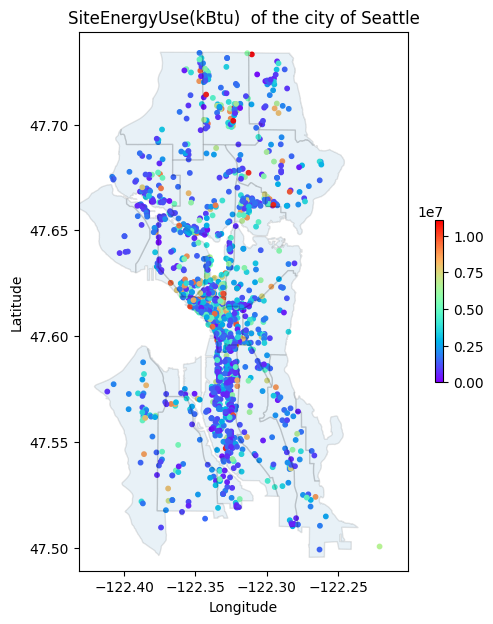

In [134]:

warnings.filterwarnings('ignore')

 # Convert Pandas dataframe to GeoDataFrame
crs={'init':'epsg:4326'} # Coordinate reference system 
gdf = geopandas.GeoDataFrame(

    eData, geometry=geopandas.points_from_xy(eData.Longitude, eData.Latitude), crs=crs
)
kings_county_map = geopandas.read_file('map\\Neighborhood_Map_Atlas_Districts.shp')
df_wm = kings_county_map.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(7,7))
gdf.plot(ax=ax, column = 'SiteEnergyUse(kBtu)', cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 10)
# gdf.plot(ax=ax, marker='o', color='red', markersize=5)   
#         
df_wm.plot(ax=ax, alpha=0.1, edgecolor='k')
minx, miny, maxx, maxy = gdf.total_bounds 
ax.set_xlim(minx -0.02, maxx +0.02)
ax.set_ylim(miny -0.01, maxy +0.01)
ax.set_title('SiteEnergyUse(kBtu)  of the city of Seattle')
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')
plt.show()

In the map above, there is a clear concentration of high energy consumption buildings in the center and on the north part.
However there is not a clear difference between neighborhood. This might be better explained by the type of building. 
Indeed most often offices and public facilities are concentrated towards the city center. That is why we will look at the impact of the building type more closely.
Furthermore, neighborhood might be less relevant than longitude and latitude, as a point might be close to, for instance the city center and not be considered as a building from the center. That is why we will take Longitude and Latitude into account in latter prediction. 

In [135]:
eData.drop('geometry',axis=1,inplace=True)

### The impact of  PrimaryPropertyType 
First let's look at the building type distribution. There is two interesting variables here, the PrimaryPropertyType and the LargestPropertyUsedType. 

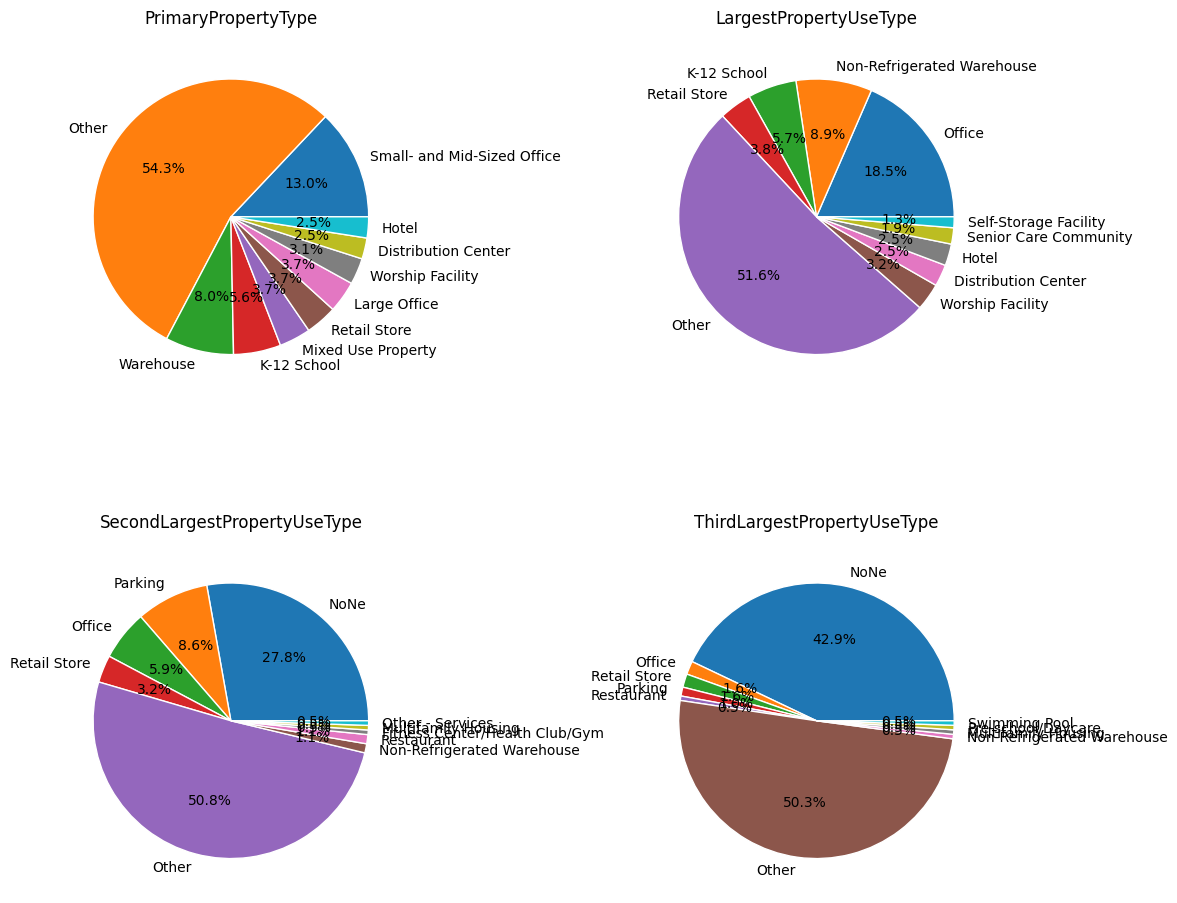

In [136]:
def getPieData(columnName,nbF): 
    counts = eData[columnName].value_counts()
    tab = pd.DataFrame(counts, columns = [columnName])
    tab = tab.sort_values(columnName,ascending=False)
    tab["frequency"] = round(tab[columnName] / len( eData[columnName]),2)
    pieData = tab["frequency"].head(nbF)
    pieData["Other"] = pieData.sum()
    return pieData

fig, axs = plt.subplots(2,2)
fig.set_figheight(12)
fig.set_figwidth(12)
List = [ 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']
i = 0 
for ax in axs.reshape(-1): 
    pieData = getPieData(List[i],10)
    pieData.plot(ax=ax ,
                    kind='pie',      
                autopct='%1.1f%%', # add auto-labeling percentage
                wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'})

    ax.set_title(List[i],pad=15)
    ax.set_ylabel("")
    i = i+1 

plt.subplots_adjust(wspace=0.7)
plt.show()

Most building are either offices or warehouse.

The primary property type distribution does not correspond to the largestPropertyUseType meaning that the usage of some building might have changed over time. 

What would be interesting here it's to compare the GFA of first second in third property use type.

In [137]:
eData.groupby('LargestPropertyUseType')['LargestPropertyUseTypeGFA'].mean().sort_values(ascending=False)[:10].index

Index(['Hospital (General Medical & Surgical)', 'Parking', 'Other - Utility',
       'Senior Care Community', 'K-12 School', 'Hotel',
       'Residence Hall/Dormitory', 'Strip Mall', 'College/University',
       'Office'],
      dtype='object', name='LargestPropertyUseType')

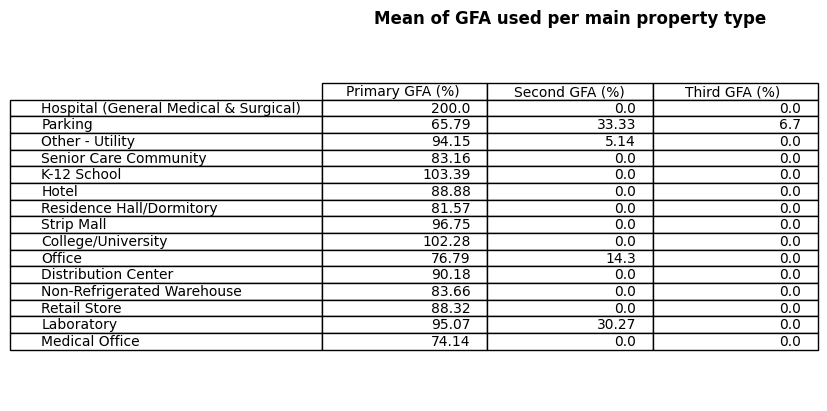

In [138]:
OutOfRange = []
variables = eData.groupby('LargestPropertyUseType')['LargestPropertyUseTypeGFA'].mean().sort_values(ascending=False)[:15].index # ['Office']
for var in variables:
    VarData = eData[eData['LargestPropertyUseType'] == var ] 
    meanGFA =  VarData['PropertyGFATotal'].median()
    
    OutOfRange.append([ \
                        round( VarData['LargestPropertyUseTypeGFA'].median() / meanGFA *100         , 2) ,      \
                        round( VarData['SecondLargestPropertyUseTypeGFA'].median()/ meanGFA *100    , 2) ,     \
                        round( VarData['ThirdLargestPropertyUseTypeGFA'].median() /meanGFA *100     , 2)      ])

fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table( cellText = OutOfRange,  rowLabels = variables,  colLabels = ["Primary GFA (%) ","Second GFA (%)","Third GFA (%) "],loc='center')         
table.auto_set_font_size(False)
table.set_fontsize(10)
ax.set_title('Mean of GFA used per main property type', 
            fontweight ="bold") 

plt.xticks(rotation = 25) # Rotates X-Axis Ticks by 45-degrees
plt.show()



What is interesting here is that some specific building have only one main type such as hospital, universities, K-12 school whereas on average, parking have multiple used types. Therefore we need to take all three usage into account for further study. 

Let's have a closer look at the LargestPropertyUseType and how the main type of the building influences the relation with the energy usage : 

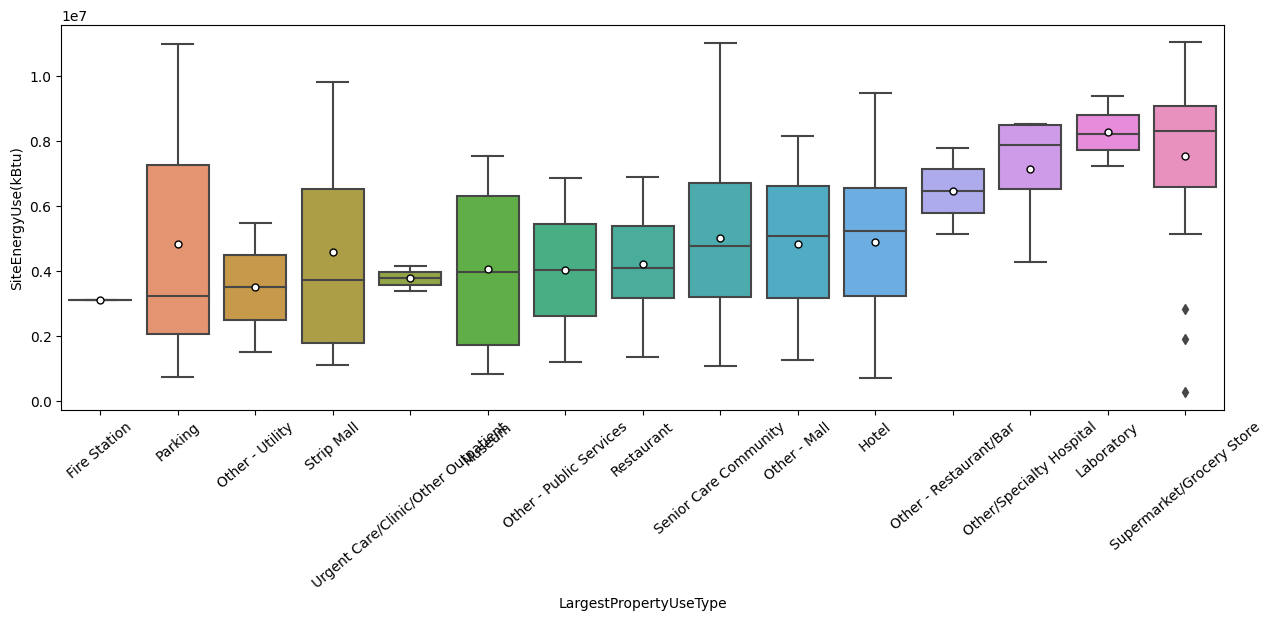

In [139]:

NB_SELECT_BUILDINGS = 15
my_order = eData.groupby('LargestPropertyUseType')['SiteEnergyUse(kBtu)'].median().sort_values().tail(NB_SELECT_BUILDINGS).index
# Give it to the boxplot
plt.figure(figsize=(15, 5))
plt.xticks(rotation = 40) # Rotates X-Axis Ticks by 45-degrees
sns.boxplot(    x='LargestPropertyUseType', y='SiteEnergyUse(kBtu)',\
                data=eData, order=my_order,\
                showmeans=True,\
                meanprops={"marker":"o",    
                            "markerfacecolor":"white", 
                            "markeredgecolor":"black",
                            "markersize":"5"}
            )

plt.show()

The median seems to differ between groups in the dataset.
Let's verify if we can generalize that by a statistical test.  
To do so let's first look at the variance between each group through a Levene test ( independence between groups clearly satisfied). 

In [140]:
types = eData['PrimaryPropertyType'].unique()
GROUPS = []
columns = []
for type in types : 
    GROUPS.append(eData[eData['PrimaryPropertyType']== type ]['SiteEnergyUse(kBtu)'])
    columns.append(area)
stats.levene(*GROUPS)

LeveneResult(statistic=5.512379794760273, pvalue=7.892397972988408e-14)

The homoscedcity is not satisfy, we **cannot proceed with an ANOVA test** . 
Let's pursue with a Krukal Wallis test : 

In [141]:
stats.kruskal(*GROUPS)

KruskalResult(statistic=440.2152248976063, pvalue=8.92226974867326e-81)

The nul Kruskal hypotethis is false, median are not all equals. 


From the former boxplots, supermarkets, Laboratories and  Hospital have a higher consumption than Parking or restaurants. 
Therefore it worth taking into account the building type in our latter prediction 

# BUILT YEAR

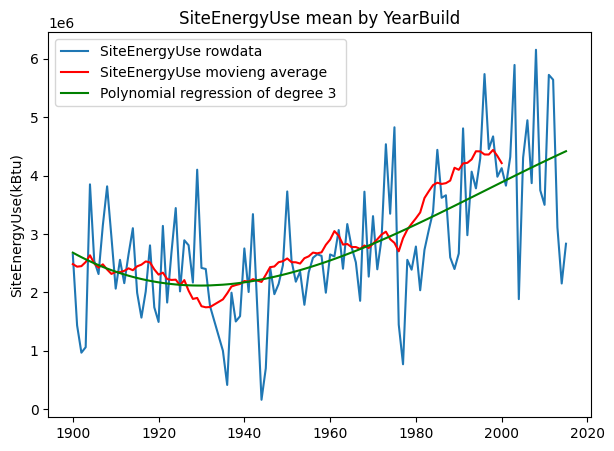

In [142]:
def MovingAverage(list,window_size) : 
    means = []
    movingidx = 0
    while (movingidx + window_size ) < len(list) : 
        means.append( sum(list[movingidx:(movingidx + window_size)]) / window_size)
        movingidx = movingidx +1
    return means 


window_size = 15
meanYearConsumption= eData.groupby("YearBuilt")['SiteEnergyUse(kBtu)'].mean()


MYCMovingAverage = pd.Series(MovingAverage(meanYearConsumption,window_size))
MYCMovingAverage.index = meanYearConsumption.index[:-window_size]


X = meanYearConsumption.index.values.reshape(-1, 1)
# PolynomialFeatures generate a new feature matrix consisting of all polynomial combinations (1,x**2,x**3)
poly = PolynomialFeatures(degree = 3)
model = LinearRegression().fit(poly.fit_transform(X), meanYearConsumption)


fig , ax = plt.subplots(figsize=(7, 5))
ax.plot(meanYearConsumption, label='SiteEnergyUse rowdata')
ax.plot(MYCMovingAverage,'r', label='SiteEnergyUse movieng average')
ax.plot(X,model.predict(poly.fit_transform(X)),'g', label='Polynomial regression of degree 3 ')
ax.set_title('SiteEnergyUse mean by YearBuild')
ax.set_ylabel('SiteEnergyUse(kBtu)')
ax.legend()
plt.show()

Here there is a clear relation between the building year and the energy consumption. 
However, as very few buildings were build during first and second world war and the second oil shock (1978-79) data from these year are not representative. 
There is a clear difference between buildings build before 1980 and building build after 1990 in term of energy consumption. 

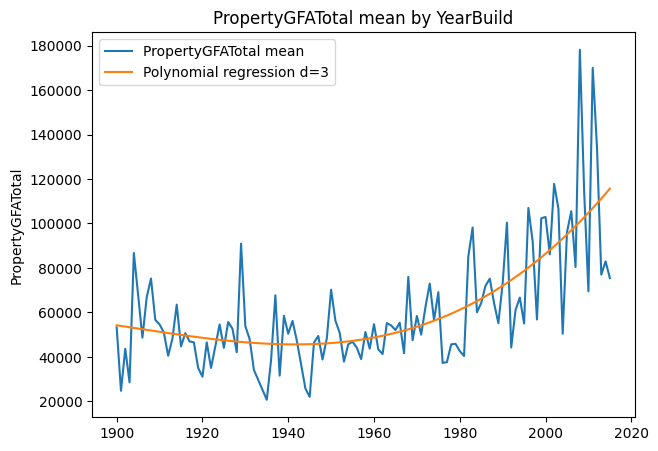

In [143]:
meanYearGFA= eData.groupby("YearBuilt")['PropertyGFATotal'].mean()

X = meanYearGFA.index.values.reshape(-1, 1)
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, meanYearGFA)


fig , ax = plt.subplots(figsize=(7, 5))
ax.plot(meanYearGFA, label='PropertyGFATotal mean')
ax.plot(X,model.predict(poly.fit_transform(X)), label='Polynomial regression d=3')
ax.set_title('PropertyGFATotal mean by YearBuild')
ax.set_ylabel('PropertyGFATotal')
ax.legend()
plt.show()


# IV. Variables selection and data preparation 

The LargestPropertyUseType is a categorical variable, but for further study we want to include it to the model. 

In [144]:

# Total energy consumption is redundant in the data (with different unit or normalization) so we can drop redundant information 
eData.drop(columns=['SiteEnergyUseWN(kBtu)','SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SiteEUIWN(kBtu/sf)','Electricity(kWh)','SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)','NaturalGas(therms)','Address','ListOfAllPropertyUseTypes','YearsENERGYSTARCertified'],inplace=True)

Let's select variables that correlate the most with the value we want to predict. 

In [145]:
eData.to_csv('prediction.csv',index=False)